In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [23]:
import pandas as pd
import configs

In [4]:
nochar_confs = configs.get_x_configs('NoChar', 4)

In [5]:
ndf = pd.DataFrame(nochar_confs)

In [6]:
ndf.iloc[:100].optimizer.value_counts()

SGD    4
Name: optimizer, dtype: int64

In [7]:
ndf.iloc[:100].lstm_layer.value_counts()

2    4
Name: lstm_layer, dtype: int64

In [8]:
ndf.iloc[:100].batch_size.value_counts()

8    4
Name: batch_size, dtype: int64

In [9]:
ndf.iloc[:100].use_char.value_counts()

False    4
Name: use_char, dtype: int64

In [10]:
lstm_confs = configs.get_x_configs('CharLSTM', 8)

In [11]:
import pandas as pd
df = pd.DataFrame(lstm_confs)

In [12]:
df.iloc[:100].optimizer.value_counts()

SGD    8
Name: optimizer, dtype: int64

In [13]:
df.iloc[:100].lstm_layer.value_counts()

2    8
Name: lstm_layer, dtype: int64

In [14]:
df.iloc[:100].batch_size.value_counts()

8    8
Name: batch_size, dtype: int64

In [15]:
df.iloc[:100].learning_rate.value_counts()

0.010    4
0.005    4
Name: learning_rate, dtype: int64

In [16]:
df.iloc[:100].char_seq_feature.value_counts()

LSTM    8
Name: char_seq_feature, dtype: int64

In [17]:
cnn_confs = configs.get_x_configs('CharCNN', 24)

In [18]:
cdf = pd.DataFrame(cnn_confs)

In [19]:
cdf.iloc[:100].optimizer.value_counts()

SGD    24
Name: optimizer, dtype: int64

In [20]:
cdf.iloc[:100].lstm_layer.value_counts()

2    24
Name: lstm_layer, dtype: int64

In [21]:
cdf.iloc[:100].batch_size.value_counts()

8    24
Name: batch_size, dtype: int64

In [22]:
cdf.iloc[:100].learning_rate.value_counts()

0.010    12
0.005    12
Name: learning_rate, dtype: int64

In [23]:
cdf.iloc[:100].char_seq_feature.value_counts()

CNN    24
Name: char_seq_feature, dtype: int64

In [24]:
import os

In [25]:
os.mkdir('hp_search/models3')

In [26]:
os.mkdir('hp_search/conf3')

In [27]:
os.mkdir('hp_search/conf_json3')

## Token

## Token Multi-Tag

## Token

# RUNNING ON NLP08, NLP10, NLP11, NLP13, NLP05, NLP14
cd NCRFpp/  
conda activate ncrf_gpu  
python run4_hp_search.py 3 token_charlstm.2  


## Check results

In [7]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [8]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [343]:
import re
import os
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+)(?:, p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+))?')
#Dev: time: 0.94s speed: 536.09st/s; acc: 0.9043
#Dev: time: 3.42s, speed: 146.59st/s; acc: 0.9546, p: 0.7577, r: 0.6393, f: 0.6935

mtimes = []
res = []
archs = []
for f in os.scandir('hp_search/logs3'):
    if f.name.startswith('.ipy'):
        continue
    mtimes.append(os.path.getmtime(f.path))
    arch = f.name.split('.')[0]
    archs.append(arch)
    unit = arch.split('_')[0]
    conf_num = f.name.split('.')[1]
    if 'cnn' in arch:
        matching_conf = cnn_confs[int(conf_num)] 
    elif 'lstm' in arch: 
        matching_conf = lstm_confs[int(conf_num)]
    elif 'nochar' in arch:
        matching_conf = nochar_confs[int(conf_num)]
    params = { 'arch': arch, 'unit': unit, 'conf_num': conf_num}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    if v is not None:
                        r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

rdf = pd.DataFrame(res)

rdf['model_file_name'] = rdf.arch + '.' + rdf.conf_num +'.model.' + rdf.epoch.astype(str) + '.model'
rdf['dset_file_name'] =  rdf.arch + '.' + rdf.conf_num +'.model.dset'
rdf['char_seq_feature'] = rdf.char_seq_feature.fillna('NoChar')

rdf['relevant_score'] = rdf.f.fillna(rdf.acc)

erdf = rdf[(rdf.groupby(['conf_num', 'arch']).relevant_score.transform(max)==rdf.relevant_score) ]
erdf = erdf[(erdf.groupby(['conf_num', 'arch']).epoch.transform(min)==erdf.epoch) ]

erdf.shape

(108, 35)

In [344]:
erdf.groupby('arch').size()

arch
morph_charcnn        24
morph_charlstm        8
morph_nochar          4
multitok_charcnn     24
multitok_charlstm     8
multitok_nochar       4
token_charcnn        24
token_charlstm        8
token_nochar          4
dtype: int64

In [345]:
from collections import Counter
archs = Counter(archs)
archs

Counter({'morph_charcnn': 24,
         'token_charcnn': 24,
         'morph_charlstm': 8,
         'multitok_charcnn': 24,
         'multitok_charlstm': 8,
         'token_nochar': 4,
         'multitok_nochar': 4,
         'token_charlstm': 8,
         'morph_nochar': 4})

In [346]:
print ('Mean time per run:', round((max(mtimes) - min(mtimes) )/ len(mtimes) / 60, 2), 'minutes')

Mean time per run: 22.86 minutes


In [348]:
import numpy as np 
def perc(n):
    def perc_(x):
        return np.percentile(x, n)
    perc_.__name__ = 'perc_%s' % n
    return perc_

erdf.groupby(['unit', 'char_seq_feature']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max     min      mean       std   median  \
unit     char_seq_feature                                                
morph    CNN               0.8021  0.7704  0.786846  0.007626  0.78555   
         LSTM              0.7974  0.7807  0.790237  0.005450  0.79135   
         NoChar            0.7826  0.7774  0.779500  0.002202  0.77900   
multitok CNN                  NaN     NaN       NaN       NaN      NaN   
         LSTM                 NaN     NaN       NaN       NaN      NaN   
         NoChar               NaN     NaN       NaN       NaN      NaN   
token    CNN               0.7789  0.7487  0.764038  0.007895  0.76445   
         LSTM              0.7749  0.7526  0.765925  0.007704  0.76750   
         NoChar            0.7484  0.7332  0.739150  0.006496  0.73750   

                            perc_95  
unit     char_seq_feature            
morph    CNN               0.799150  
         LSTM              0.796245  
         NoChar            0.782075  
multitok CNN                    NaN  
         LSTM                   NaN  
         NoChar                 NaN  
token    CNN               0.776290  
         LSTM              0.774830  
         NoChar            0.746810

## Evaluate files (Mention Evaluation)

In [349]:
import sys
sys.path.append('../NER')

In [350]:
import ne_evaluate_mentions as nem

## Create configs for decoding

In [351]:
model_folder = 'hp_search/models3'
output_folder = 'hp_search/decode_output3'
conf_folder = 'hp_search/decode_conf3'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
    
decode_sets = {
    'morph': {
        'morph_dev_gold': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'morph_dev_yap': '../NER/data/for_ncrf/morph_yap_dev_dummy_o.bmes',
        'morph_test_gold': '../NER/data/for_ncrf/morph_gold_test.bmes',
        'morph_test_yap': '../NER/data/for_ncrf/morph_yap_test_dummy_o.bmes',
    },
    'token': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_fix.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_fix.bmes',
    },
    'multitok': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_concat.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_concat.bmes',
    }
}

params = { 'status': 'decode' }

for i, row in erdf.iterrows():
    unit = row['arch'].split('_')[0]
    for name, set_path in decode_sets[unit].items():
        row_par = params.copy()
        row_par['load_model_dir'] = os.path.join(model_folder, row['model_file_name'])
        row_par['dset_dir'] = os.path.join(model_folder, row['dset_file_name'])
        row_par['decode_dir'] = os.path.join(output_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.bmes')
        row_par['raw_dir'] = set_path
        
        conf_path = os.path.join(conf_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.decode.conf')
        if not os.path.exists(conf_path):
            with open(conf_path, 'w', encoding='utf8') as of:
                for k, v in row_par.items():
                    of.write(k+'='+str(v)+'\n')        
 

## Evaluate decoded folder

In [353]:
scores = {}

In [354]:
scores = pickle.load(open('hp_search/scores3.pkl', 'rb'))

In [355]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, arch, conf_num = file.name.split('.')[:3]
    if (gold_name, arch, conf_num) not in scores:
        _, charsf = arch.split('_')
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file)
        scores[(gold_name, arch, conf_num)] = (p, r, f)
    

In [356]:
pickle.dump(scores, open('hp_search/scores3.pkl', 'wb'))

In [357]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [358]:
mev = pd.DataFrame(score_tups, columns=('gold_name', 'arch', 'conf_num', 'p', 'r', 'f'))
mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'arch']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max       min      mean       std  \
gold_name      arch                                                        
morph_dev_gold morph_charcnn      0.801706  0.769902  0.787767  0.007600   
               morph_charlstm     0.797009  0.782422  0.790866  0.004829   
               morph_nochar       0.784314  0.778261  0.780220  0.002797   
morph_dev_yap  morph_charcnn      0.722838  0.697928  0.711386  0.007143   
               morph_charlstm     0.719647  0.712594  0.715196  0.002471   
               morph_nochar       0.702643  0.694414  0.697347  0.003672   
token_dev      multitok_charcnn   0.762621  0.730975  0.743628  0.008251   
               multitok_charlstm  0.763754  0.741935  0.751293  0.007145   
               multitok_nochar    0.753994  0.732181  0.743360  0.012012   
               token_charcnn      0.778857  0.748652  0.764794  0.007947   
               token_charlstm     0.774947  0.753410  0.766869  0.007495   
               token_nochar       0.750542  0.733985  0.740261  0.007156   

                                    median   perc_95  
gold_name      arch                                   
morph_dev_gold morph_charcnn      0.787223  0.800837  
               morph_charlstm     0.791073  0.796582  
               morph_nochar       0.779154  0.783621  
morph_dev_yap  morph_charcnn      0.711377  0.722172  
               morph_charlstm     0.714820  0.719033  
               morph_nochar       0.696166  0.701777  
token_dev      multitok_charcnn   0.740699  0.757553  
               multitok_charlstm  0.748528  0.761906  
               multitok_nochar    0.743632  0.753919  
               token_charcnn      0.765344  0.776385  
               token_charlstm     0.768324  0.774853  
               token_nochar       0.738258  0.748775

In [359]:
mev['pred_set'] = mev.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]).replace('_yap', ''))

In [360]:
mev = mev.set_index(['arch', 'conf_num', 'pred_set'])[['p', 'r', 'f']].unstack()
mev.columns = ['_'.join(col).rstrip('_') for col in mev.columns.values]
mev.head()

p_dev  p_dev_gold    p_test  p_test_gold     r_dev  \
arch          conf_num                                                          
morph_charcnn 00        0.662651    0.740964  0.619099     0.732833  0.787589   
              01        0.632530    0.712851  0.633047     0.752146  0.781638   
              02        0.654618    0.736948  0.638412     0.754292  0.779904   
              03        0.652610    0.734940  0.636266     0.756438  0.775656   
              04        0.662651    0.740964  0.633047     0.746781  0.758621   

                        r_dev_gold    r_test  r_test_gold     f_dev  \
arch          conf_num                                                
morph_charcnn 00          0.858140  0.700243     0.787774  0.719738   
              01          0.853365  0.736579     0.824706  0.699223   
              02          0.857477  0.714286     0.805269  0.711790   
              03          0.847222  0.726716     0.820722  0.708833   
              04          0.827354  0.711701     0.800000  0.707395   

                        f_dev_gold    f_test  f_test_gold  
arch          conf_num                                     
morph_charcnn 00          0.795259  0.657175     0.759311  
              01          0.776805  0.680900     0.786756  
              02          0.792657  0.674221     0.778947  
              03          0.787097  0.678490     0.787270  
              04          0.781780  0.670074     0.772475

In [361]:
erdf = erdf.merge(mev.reset_index(), on=['arch', 'conf_num'])

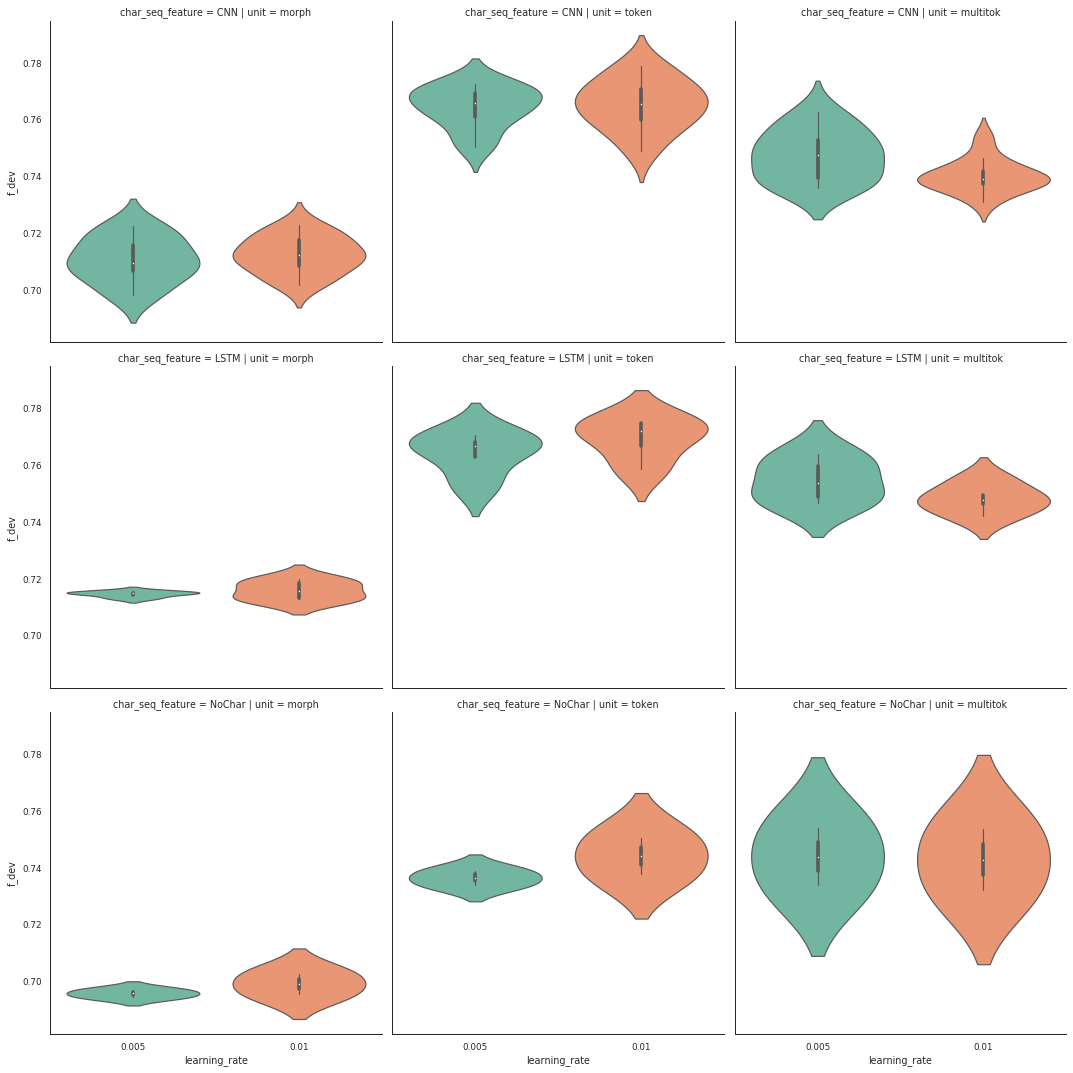

In [362]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f_dev", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

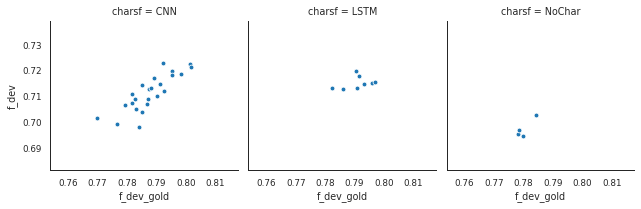

In [312]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col='charsf')
>>> g = g.map(plt.scatter, "f_dev_gold", "f_dev", edgecolor="w")

In [313]:
cols = ['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
        'learning_rate', 'char_hidden_dim', 'char_kernel_size',
        'hidden_dim', 'dropout', 'epoch']

In [245]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

,arch,conf_num,epoch,f
69,morph_charlstm,1,192,0.7974
17,morph_charcnn,20,74,0.7966
0,morph_charcnn,00,110,0.7957
2,morph_charlstm,0,111,0.7941
31,morph_charlstm,7,172,0.7936
19,morph_charcnn,02,134,0.7931
65,morph_charlstm,6,140,0.7918
55,morph_charcnn,22,81,0.7918
66,morph_charlstm,4,135,0.7909
67,morph_charlstm,5,54,0.7891


In [246]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

,arch,conf_num,epoch,f
1,token_charcnn,00,177,0.7789
43,token_charcnn,22,104,0.7771
72,token_charlstm,4,102,0.7749
45,token_charlstm,2,128,0.7747
33,token_charcnn,04,191,0.7717
52,token_charcnn,05,158,0.7707
22,token_charcnn,11,141,0.7702
57,token_charcnn,23,199,0.7699
18,token_charcnn,03,101,0.7694
59,token_charlstm,3,164,0.7692


In [247]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
69,0.7974,0.8519,0.7495,LSTM,2,8,0.005,70,,200,0.5,192
17,0.7966,0.8605,0.7415,CNN,2,8,0.010,50,5,200,0.5,74
0,0.7957,0.8585,0.7415,CNN,2,8,0.010,70,7,200,0.4,110
2,0.7941,0.8344,0.7575,LSTM,2,8,0.005,50,,200,0.5,111
31,0.7936,0.8458,0.7475,LSTM,2,8,0.005,70,,200,0.4,172
19,0.7931,0.8578,0.7375,CNN,2,8,0.010,70,3,200,0.5,134
65,0.7918,0.8575,0.7355,LSTM,2,8,0.010,70,,200,0.4,140
55,0.7918,0.8629,0.7315,CNN,2,8,0.010,70,7,200,0.5,81
66,0.7909,0.8608,0.7315,LSTM,2,8,0.010,70,,200,0.5,135
67,0.7891,0.8235,0.7575,LSTM,2,8,0.005,50,,200,0.4,54


In [248]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
35,0.7704,0.8429,0.7094,CNN,2,8,0.010,50,7,200,0.4,185
3,0.7760,0.8534,0.7114,CNN,2,8,0.005,70,7,200,0.5,175
14,0.7774,0.8483,0.7174,NoChar,2,8,0.010,,,200,0.5,71
34,0.7789,0.8435,0.7234,NoChar,2,8,0.005,,,200,0.5,57
70,0.7791,0.8333,0.7315,NoChar,2,8,0.005,,,200,0.4,104
58,0.7801,0.8255,0.7395,CNN,2,8,0.005,50,3,200,0.5,184
68,0.7813,0.8548,0.7194,CNN,2,8,0.010,50,7,200,0.5,109
21,0.7821,0.8326,0.7375,CNN,2,8,0.005,50,7,200,0.5,71
53,0.7826,0.8551,0.7214,NoChar,2,8,0.010,,,200,0.4,139
32,0.7832,0.8481,0.7275,CNN,2,8,0.005,70,3,200,0.5,194


In [249]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
1,0.7789,0.8435,0.7234,CNN,2,8,0.010,70.0,7,200,0.4,177
43,0.7771,0.8447,0.7194,CNN,2,8,0.010,70.0,7,200,0.5,104
72,0.7749,0.8239,0.7315,LSTM,2,8,0.010,70.0,,200,0.5,102
45,0.7747,0.8337,0.7234,LSTM,2,8,0.010,50.0,,200,0.5,128
33,0.7717,0.8432,0.7114,CNN,2,8,0.005,50.0,3,200,0.5,191
52,0.7707,0.8465,0.7074,CNN,2,8,0.010,70.0,5,200,0.4,158
22,0.7702,0.8209,0.7255,CNN,2,8,0.005,70.0,3,200,0.5,141
57,0.7699,0.8306,0.7174,CNN,2,8,0.005,70.0,7,200,0.4,199
18,0.7694,0.8190,0.7255,CNN,2,8,0.010,70.0,5,200,0.5,101
59,0.7692,0.8238,0.7214,LSTM,2,8,0.010,50.0,,200,0.4,164


In [250]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
23,0.7332,0.7991,0.6774,NoChar,2,8,0.005,,,200,0.5,198
41,0.7372,0.7895,0.6914,NoChar,2,8,0.005,,,200,0.4,78
8,0.7378,0.8071,0.6794,NoChar,2,8,0.010,,,200,0.5,138
37,0.7484,0.8156,0.6914,NoChar,2,8,0.010,,,200,0.4,80
10,0.7487,0.8107,0.6954,CNN,2,8,0.010,50,5,200,0.5,148
39,0.7526,0.7890,0.7194,LSTM,2,8,0.005,70,,200,0.4,102
9,0.7579,0.8270,0.6994,CNN,2,8,0.005,50,7,200,0.4,82
38,0.7585,0.8124,0.7114,CNN,2,8,0.010,50,5,200,0.4,54
42,0.7588,0.8077,0.7154,LSTM,2,8,0.010,70,,200,0.4,129
26,0.7591,0.8190,0.7074,CNN,2,8,0.010,50,7,200,0.4,129


In [251]:
erdf.groupby('arch').epoch.agg(['median', 'mean', 'std'])

,median,mean,std
arch,,,
morph_charcnn,110.0,121.600000,46.336965
morph_charlstm,137.5,134.000000,48.526282
morph_nochar,87.5,92.750000,36.591210
multitok_charcnn,78.0,92.461538,54.976685
multitok_charlstm,53.5,65.666667,43.366654
multitok_nochar,163.5,150.250000,48.210476
token_charcnn,129.0,126.466667,46.830800
token_charlstm,129.0,133.428571,27.263267
token_nochar,109.0,123.500000,56.929781


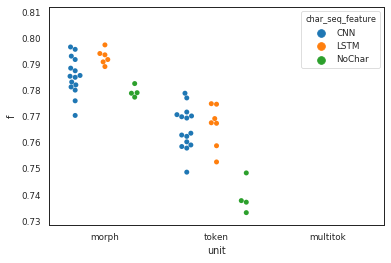

In [252]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='char_seq_feature', dodge=True)


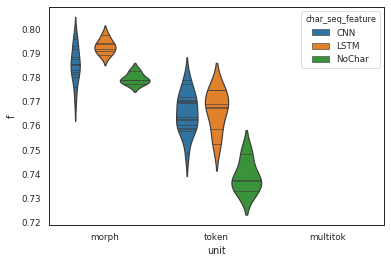

In [253]:
sns.violinplot(data=erdf, x='unit', y='f', hue='char_seq_feature', inner='stick')


## Learning rate

In [254]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                      6               4             2   
          0.010                      9               2             2   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                         4                  3                2   
          0.010                         9                  3                2   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                      7               3             2  
          0.010                      8               4             2

In [369]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f_dev.median().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005               0.709465        0.714820      0.695643   
          0.010               0.712166        0.715544      0.699051   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                  0.747448           0.753834          0.74388   
          0.010                  0.739018           0.747734          0.74284   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005               0.765686        0.766687      0.736371  
          0.010               0.765248        0.771954      0.744150

In [370]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f_dev.max().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005               0.722343        0.715517      0.696872   
          0.010               0.722838        0.719647      0.702643   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                  0.762621           0.763754         0.753994   
          0.010                  0.753498           0.754797         0.753498   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005               0.772579        0.770544      0.738758  
          0.010               0.778857        0.774947      0.750542

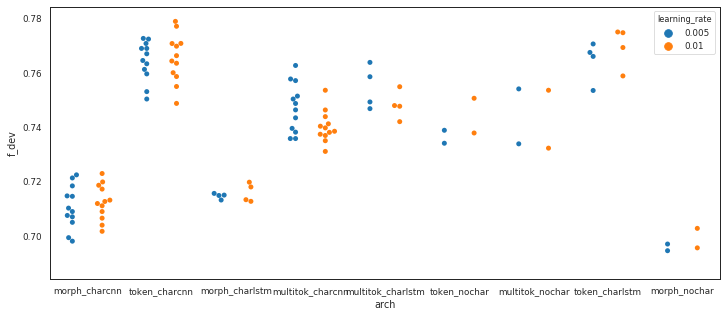

In [371]:
plt.figure(figsize=(12,5))
g = sns.swarmplot(data=erdf, hue='learning_rate', y='f_dev', x='arch', split=True)


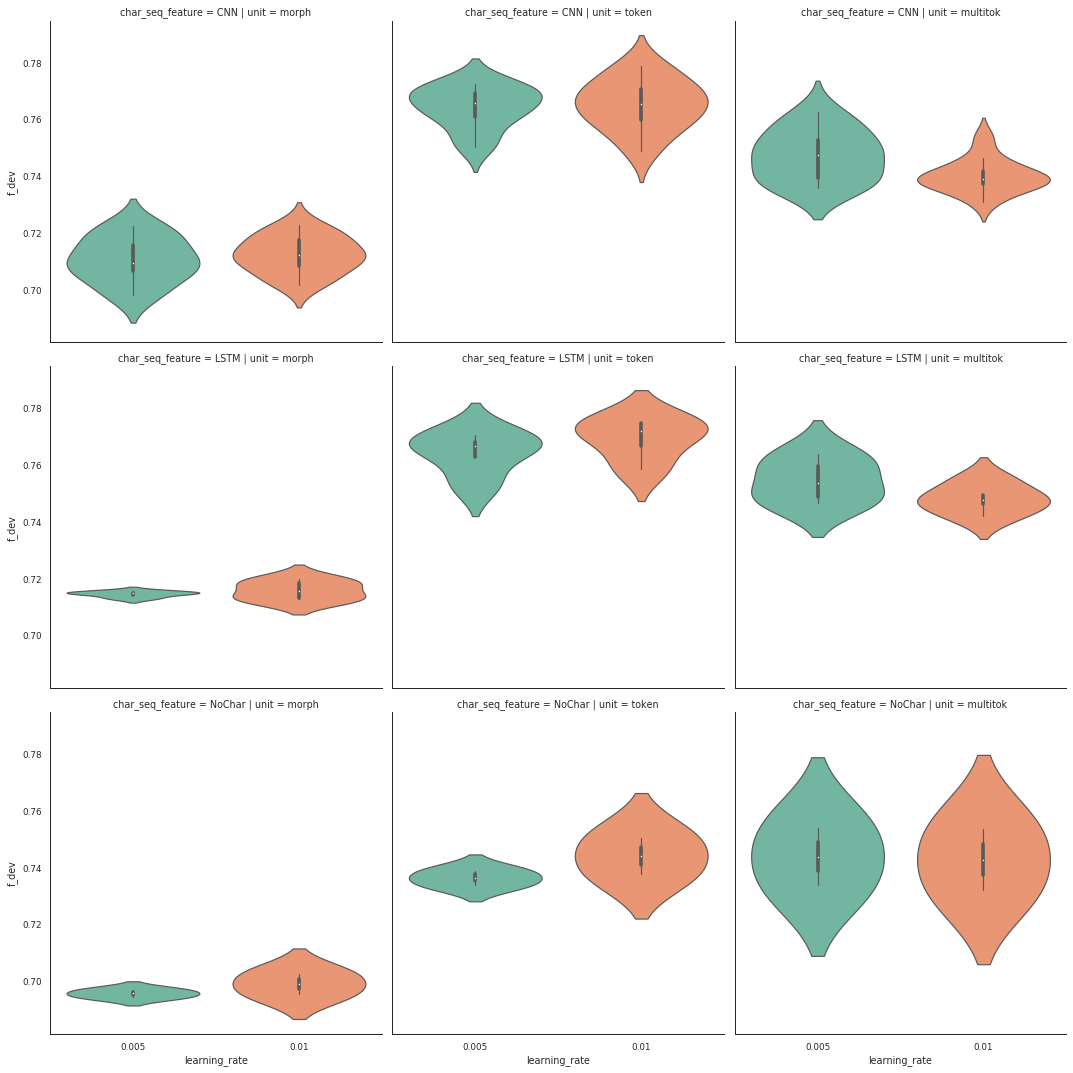

In [372]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f_dev", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

In [367]:
from scipy.stats import f_oneway

anov = {}
for a in erdf.arch.unique():
        anov[a] = f_oneway(erdf[(erdf.arch==a) & (erdf.learning_rate==0.005)].f_dev,
                             erdf[(erdf.arch==a) & (erdf.learning_rate==0.01)].f_dev,
                )
anov

{'morph_charcnn': F_onewayResult(statistic=0.3514586953173146, pvalue=0.5593339139749647),
 'token_charcnn': F_onewayResult(statistic=0.0771596590993828, pvalue=0.7837778231754038),
 'morph_charlstm': F_onewayResult(statistic=0.49219769802231916, pvalue=0.509232009945927),
 'multitok_charcnn': F_onewayResult(statistic=5.257720731107426, pvalue=0.03177708451187799),
 'multitok_charlstm': F_onewayResult(statistic=1.84811964836796, pvalue=0.2228723529723455),
 'token_nochar': F_onewayResult(statistic=1.299860885165304, pvalue=0.37237443984090374),
 'multitok_nochar': F_onewayResult(statistic=0.005010121125031671, pvalue=0.9500119922892459),
 'token_charlstm': F_onewayResult(statistic=0.9038546262552934, pvalue=0.37845825246584375),
 'morph_nochar': F_onewayResult(statistic=0.8062072163964622, pvalue=0.46400162620994634)}

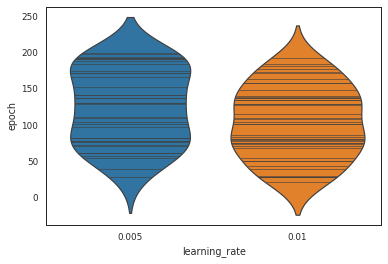

In [160]:
sns.violinplot(data=erdf, x='learning_rate', y='epoch', inner='stick')

### Do the lower scores in the lower learning rate come from lack of epochs?

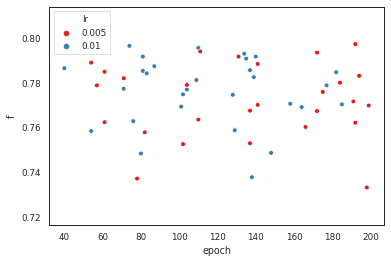

In [161]:
sns.scatterplot(data=erdf.assign(lr=lambda x: x.learning_rate.astype('str')), hue='lr', x='epoch', y='f',
               palette=sns.color_palette("Set1", erdf.learning_rate.nunique()))

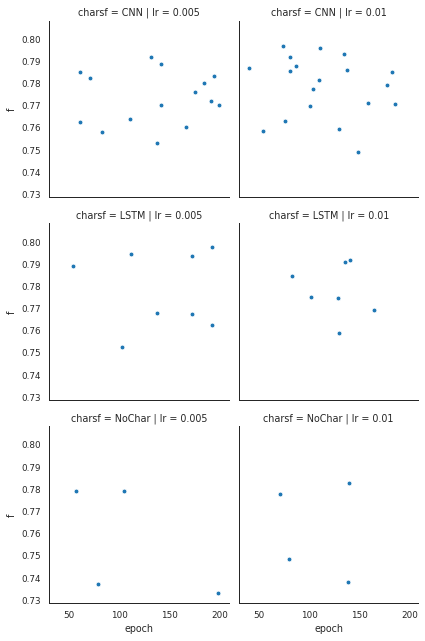

In [162]:
>>> g = sns.FacetGrid(erdf.rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='token'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
sns.swarmplot(data=erdf, x='arch', y='epoch')

## Char CNN window size

In [257]:
erdf.groupby(['unit', 'char_kernel_size']).f_dev.mean().unstack()

char_kernel_size,3.0,5.0,7.0
unit,,,
morph,0.707961,0.714816,0.709523
multitok,0.741086,0.738551,0.741035
token,0.769727,0.762377,0.767392


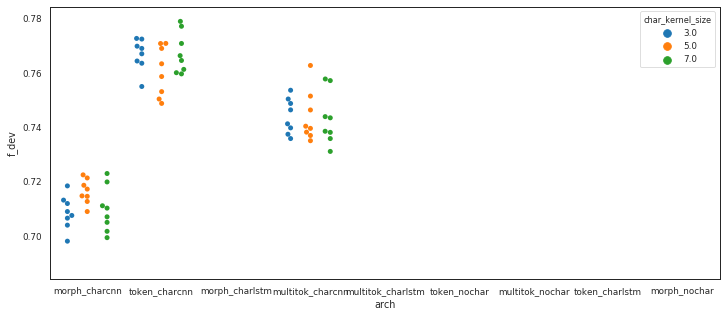

In [376]:
plt.figure(figsize=(12,5))
sns.swarmplot(data=erdf, x='arch', y='f_dev', hue='char_kernel_size', split=True)


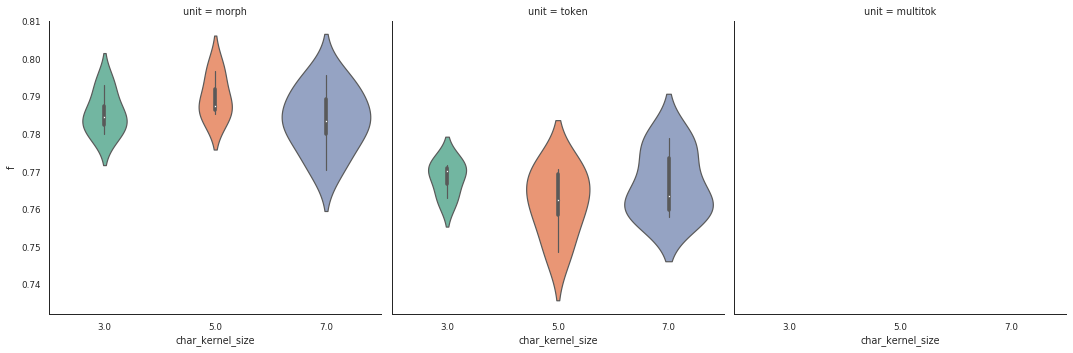

In [259]:
sns.catplot(kind='violin', col='unit', x="char_kernel_size", y="f",
                data=erdf, palette="Set2", 
                scale="count", inner="box")

In [366]:
from scipy.stats import f_oneway

anov = {}
for a in erdf.arch.unique():
    if 'charcnn' in a:
        anov[a] = f_oneway(erdf[(erdf.arch==a) &   (erdf.char_kernel_size==3)].f_dev,
                             erdf[(erdf.arch==a) & (erdf.char_kernel_size==5)].f_dev,
                             erdf[(erdf.arch==a) & (erdf.char_kernel_size==7)].f_dev
                )
anov

{'morph_charcnn': F_onewayResult(statistic=3.330133206016778, pvalue=0.05543841791179827),
 'token_charcnn': F_onewayResult(statistic=1.8964817691427374, pvalue=0.17492583543719756),
 'multitok_charcnn': F_onewayResult(statistic=0.024631743094830533, pvalue=0.9756972877812344)}

## Dropout

In [260]:
erdf.groupby(['dropout', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,multitok_charcnn,multitok_charlstm,multitok_nochar,token_charcnn,token_charlstm,token_nochar
dropout,,,,,,,,,
0.4,0.7866,0.7918,0.78085,NaN,NaN,NaN,0.7624,0.75880,0.7428
0.5,0.7832,0.7941,0.77815,NaN,NaN,NaN,0.7665,0.77115,0.7355


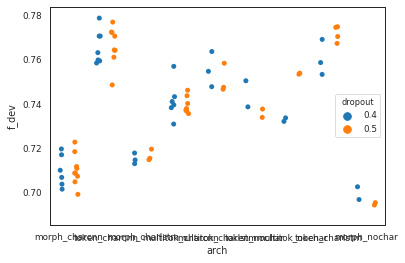

In [270]:
sns.stripplot(data=erdf, x='arch', y='f_dev', hue='dropout', dodge=True)


## Hidden dimensions

### CLSTM / CCNN

In [271]:
erdf.groupby(['char_hidden_dim', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,multitok_charcnn,multitok_charlstm,token_charcnn,token_charlstm
char_hidden_dim,,,,,,
50.0,0.78210,0.7916,NaN,NaN,0.7588,0.7692
70.0,0.78555,0.7927,NaN,NaN,0.7699,0.7631


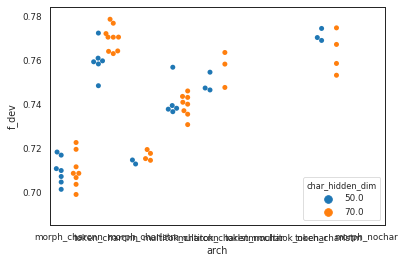

In [273]:
sns.swarmplot(data=erdf, x='arch', y='f_dev', hue='char_hidden_dim', split=True)

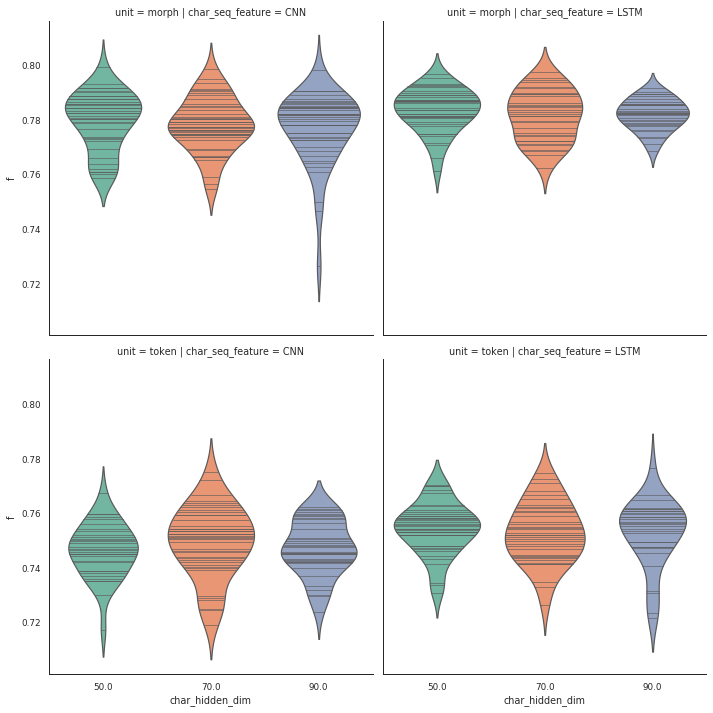

In [2441]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="char_hidden_dim", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

In [373]:
relevant_cols = ['arch', 'f_dev', 'char_hidden_dim', 'char_kernel_size', 'learning_rate']

In [375]:
erdf[relevant_cols].groupby('arch').apply(lambda x: x.sort_values('f_dev', ascending=False).head(2))

arch     f_dev  char_hidden_dim  \
arch                                                                  
morph_charcnn     55       morph_charcnn  0.722838             70.0   
                  100      morph_charcnn  0.722343             50.0   
morph_charlstm    66      morph_charlstm  0.719647             70.0   
                  65      morph_charlstm  0.717892             70.0   
morph_nochar      53        morph_nochar  0.702643              NaN   
                  70        morph_nochar  0.696872              NaN   
multitok_charcnn  78    multitok_charcnn  0.762621             70.0   
                  98    multitok_charcnn  0.757642             50.0   
multitok_charlstm 51   multitok_charlstm  0.763754             70.0   
                  28   multitok_charlstm  0.758475             70.0   
multitok_nochar   29     multitok_nochar  0.753994              NaN   
                  12     multitok_nochar  0.753498              NaN   
token_charcnn     1        token_charcnn  0.778857             70.0   
                  43       token_charcnn  0.777056             70.0   
token_charlstm    72      token_charlstm  0.774947             70.0   
                  45      token_charlstm  0.774678             50.0   
token_nochar      37        token_nochar  0.750542              NaN   
                  41        token_nochar  0.738758              NaN   

                       char_kernel_size  learning_rate  
arch                                                    
morph_charcnn     55                7.0          0.010  
                  100               5.0          0.005  
morph_charlstm    66                NaN          0.010  
                  65                NaN          0.010  
morph_nochar      53                NaN          0.010  
                  70                NaN          0.005  
multitok_charcnn  78                5.0          0.005  
                  98                7.0          0.005  
multitok_charlstm 51                NaN          0.005  
                  28                NaN          0.005  
multitok_nochar   29                NaN          0.005  
                  12                NaN          0.010  
token_charcnn     1                 7.0          0.010  
                  43                7.0          0.010  
token_charlstm    72                NaN          0.010  
                  45                NaN          0.010  
token_nochar      37                NaN          0.010  
                  41                NaN          0.005

In [2443]:
rdf[rdf.groupby('arch').f.transform(max)==rdf.f].sort_values('f', ascending=False).T

,17957,13826,40290,9968,50194,44894
acc,0.97,0.9679,0.9666,0.9668,0.9655,0.9623
p,0.8558,0.8519,0.8612,0.8277,0.8424,0.8137
r,0.7495,0.7495,0.7214,0.7315,0.7174,0.6914
f,0.7991,0.7974,0.7852,0.7766,0.7749,0.7476
arch,morph_charcnn,morph_charlstm,morph_nochar,token_charlstm,token_charcnn,token_nochar
unit,morph,morph,morph,token,token,token
conf_num,017,011,071,017,075,014
word_seq_feature,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM
word_emb_dim,300,300,300,300,300,300
char_emb_dim,30,30,30,30,30,30
